In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from prophet import Prophet
from openpyxl.workbook import Workbook
from matplotlib import pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import cx_Oracle
from config import oracle_wfm_key
import time
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy.types import String
import ipynbname
from tqdm import tqdm
import itertools
import databases as db

ods = db.oracle('cco_wfm',oracle_wfm_key)

file = ipynbname.name()
output_path=r'\\Tds\Metrocom\Contact Center\Workforce Management\Forecasting Models\Forecast Outputs\\'

In [2]:
service = ['Cable Specialist','OB_OCB_Cable_Con_Spec']
yesterday = dt.date.today() - dt.timedelta(days=1)
appended_data = []
for name in service:
    query = f'''SELECT "A1"."DateTime",
                "A1"."Queue",
                "A1"."Forecasted_AHT",
                "A1"."Forecasted_CV",
                "A1"."Actual_AHT",
                "A1"."Actual_CV"
        FROM "CCO_WFM"."Queue_Analytics" "A1"
        WHERE "A1"."Queue" = '{name}'
            AND "A1"."DateTime" <= TO_DATE('{yesterday}','YYYY-MM-DD')'''
    data = pd.read_sql(query, ods)
    appended_data.append(data)
appended_data = pd.concat(appended_data)
appended_data.head(3)

DateTime             Queue  Forecasted_AHT  Forecasted_CV  \
0 2017-02-06 13:15:00  Cable Specialist           730.0            4.0   
1 2017-02-06 13:30:00  Cable Specialist           679.0            8.0   
2 2017-02-06 13:45:00  Cable Specialist           665.0            7.0   

   Actual_AHT  Actual_CV  
0       848.0        5.0  
1       686.0        4.0  
2       686.0        4.0

## Volume Forecasts

In [3]:
grouped_cv = appended_data.groupby(['DateTime'])['Actual_CV'].sum()
grouped_cv = grouped_cv.reset_index()
grouped_cv.head(3)

DateTime  Actual_CV
0 2017-01-02 09:00:00        2.0
1 2017-01-02 09:15:00        2.0
2 2017-01-02 09:30:00        2.0

In [4]:
weekly_cv = grouped_cv.resample('W', on='DateTime').sum()
weekly_cv.head(3)

Actual_CV
DateTime             
2017-01-08      846.0
2017-01-15      985.0
2017-01-22      945.0

In [5]:
grouped_fcv = appended_data.groupby(['DateTime'])['Forecasted_CV'].sum()
grouped_fcv = grouped_fcv.reset_index()
grouped_fcv.head(3)

DateTime  Forecasted_CV
0 2017-01-02 09:00:00            2.0
1 2017-01-02 09:15:00            1.0
2 2017-01-02 09:30:00            2.0

In [6]:
weekly_fcv = grouped_fcv.resample('W', on='DateTime').sum()
weekly_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-08          734.0
2017-01-15          879.0
2017-01-22          674.0

In [7]:
column_names = ['ds','for_y']
weekly_for = weekly_fcv.reset_index()
weekly_for.columns = column_names
weekly_for = weekly_for.replace(0,np.nan)
weekly_for.tail(3)

ds   for_y
293 2022-08-21  2557.0
294 2022-08-28  2546.0
295 2022-09-04     NaN

In [8]:
column_names = ['ds','y']
weekly_data = weekly_cv.reset_index()
weekly_data.columns = column_names
weekly_data = weekly_data.replace(0,np.nan)
weekly_data.tail(3)

ds       y
293 2022-08-21  2594.0
294 2022-08-28  2496.0
295 2022-09-04     NaN

#### Initiate Prophet

In [9]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
397 2024-08-18
398 2024-08-25
399 2024-09-01

In [11]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds         yhat   yhat_lower   yhat_upper
397 2024-08-18  2258.934776  1931.736608  2607.495794
398 2024-08-25  2243.638721  1904.400138  2591.268020
399 2024-09-01  2239.172368  1908.609091  2583.087794

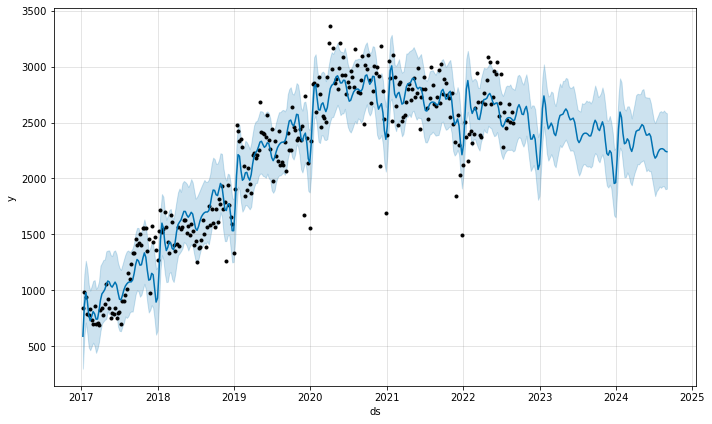

In [12]:
fig1 = m.plot(forecast)

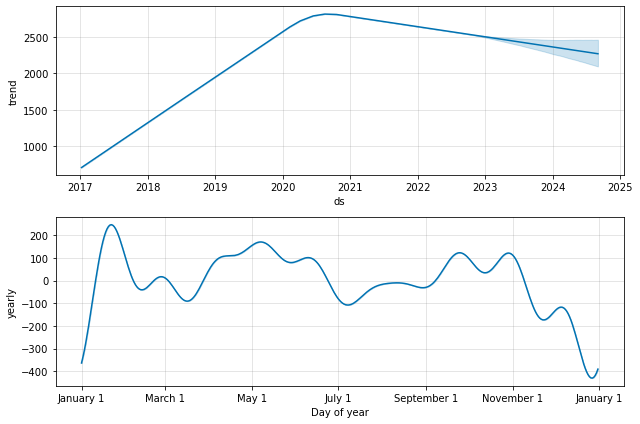

In [13]:
fig2 = m.plot_components(forecast)


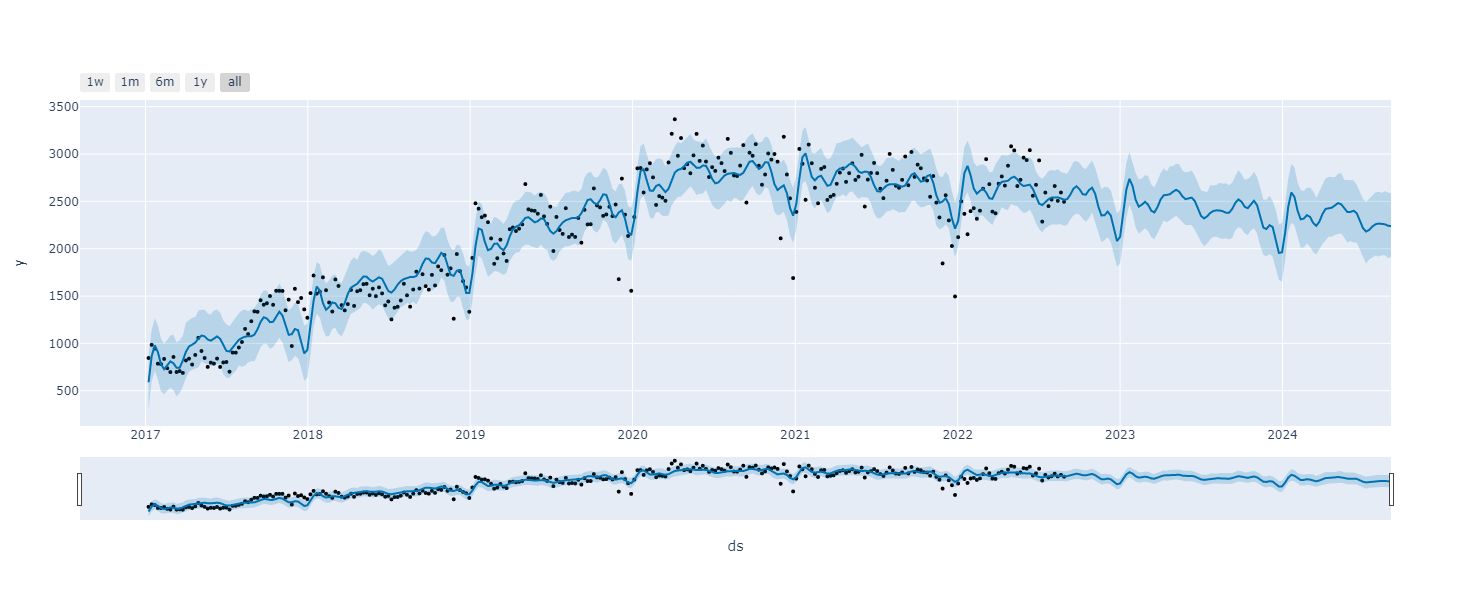

In [14]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

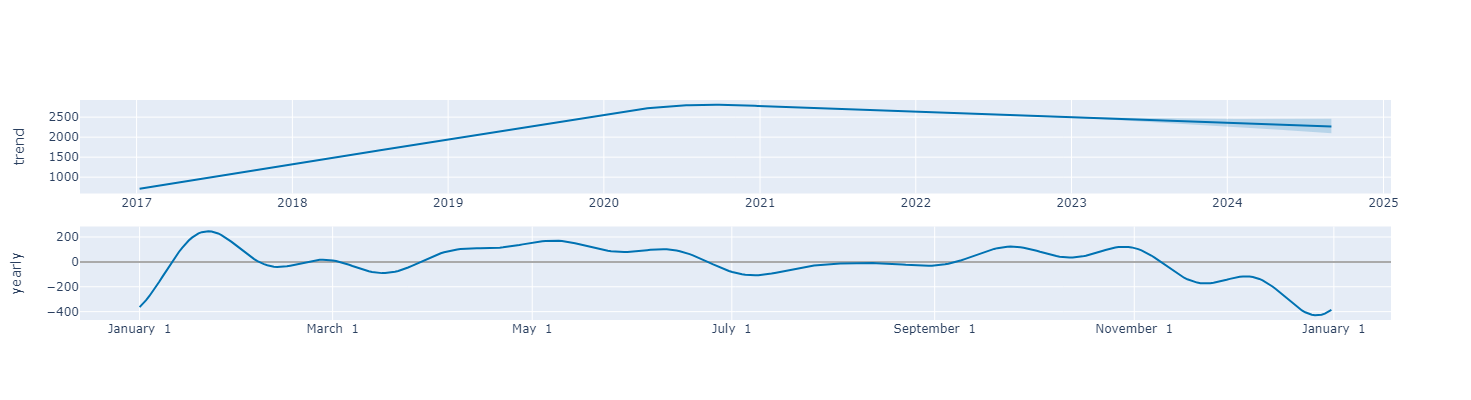

In [15]:
plot_components_plotly(m, forecast)


In [16]:
forecast.tail(3)

ds        trend   yhat_lower   yhat_upper  trend_lower  \
397 2024-08-18  2273.199808  1931.736608  2607.495794  2104.636461   
398 2024-08-25  2270.535508  1904.400138  2591.268020  2099.488262   
399 2024-09-01  2267.871209  1908.609091  2583.087794  2094.888292   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
397  2459.615860      -14.265032            -14.265032            -14.265032   
398  2459.902820      -26.896788            -26.896788            -26.896788   
399  2460.041276      -28.698841            -28.698841            -28.698841   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
397 -14.265032    -14.265032    -14.265032                   0.0   
398 -26.896788    -26.896788    -26.896788                   0.0   
399 -28.698841    -28.698841    -28.698841                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
397                         0.0                         0.0  2258.934776  
398                         0.0                         0.0  2243.638721  
399                         0.0                         0.0  2239.172368

#### Cross Validation

In [17]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 41 forecasts with cutoffs between 2021-01-15 00:00:00 and 2022-07-29 00:00:00


  0%|          | 0/41 [00:00<?, ?it/s]

ds         yhat   yhat_lower   yhat_upper       y     cutoff
0 2021-01-17  3404.507227  3132.602496  3669.194116  2897.0 2021-01-15
1 2021-01-24  3482.552645  3206.984154  3745.260656  2517.0 2021-01-15
2 2021-01-31  3363.439987  3101.843300  3647.957126  3100.0 2021-01-15

In [18]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon            mse        rmse         mae      mape     mdape  \
0  2 days   61235.553443  247.458185  203.563043  0.077702  0.062417   
1  9 days  123887.702885  351.976850  256.417879  0.106170  0.063332   
2 16 days   70564.954125  265.640648  220.894119  0.084772  0.063731   

      smape  coverage  
0  0.075945  0.634146  
1  0.098364  0.658537  
2  0.082720  0.634146

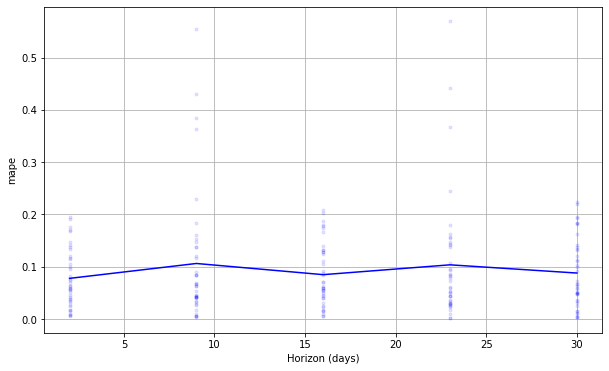

In [19]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

### SQL Export

In [20]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly" "A1"
                WHERE
                    "A1"."Team" = '{team}'
                    
                    AND "A1"."DS" <= TO_DATE({end_date},'YYYY-MM-DD HH24:MI:SS')'''

with ods as conn:
    conn.execute(delete)

In [21]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 400...Done. 0.10399413108825684 total seconds have elapsed.


## AHT Forecasts

In [22]:
appended_data['Adj_AHT'] = appended_data['Actual_AHT'] * appended_data['Actual_CV']
appended_data['Adj_AHT'] = appended_data['Adj_AHT'].replace(0, np.nan)
grouped_aht = appended_data.groupby(['DateTime'])['Adj_AHT'].sum()
grouped_aht = grouped_aht.reset_index()
grouped_aht.head(3)

DateTime  Adj_AHT
0 2017-01-02 09:00:00    770.0
1 2017-01-02 09:15:00    770.0
2 2017-01-02 09:30:00   1088.0

In [23]:
combined_aht = grouped_aht
combined_aht['Actual_AHT'] = grouped_aht['Adj_AHT'] / grouped_cv['Actual_CV']
combined_aht.head(3)

DateTime  Adj_AHT  Actual_AHT
0 2017-01-02 09:00:00    770.0       385.0
1 2017-01-02 09:15:00    770.0       385.0
2 2017-01-02 09:30:00   1088.0       544.0

In [24]:
subdaily_adj = grouped_aht[['DateTime','Adj_AHT']]
subdaily_adj['Adj_AHT'] = subdaily_adj['Adj_AHT'].replace(0, np.nan)
weekly_adj = subdaily_adj.resample('W', on='DateTime').sum()
weekly_adj.head(3)

C:\Users\usrocu\AppData\Local\Temp\ipykernel_14304\3997668832.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Adj_AHT
DateTime            
2017-01-08  531184.0
2017-01-15  612380.0
2017-01-22  629381.0

In [25]:
subdaily_cv = grouped_cv[['DateTime','Actual_CV']]
weekly_cv = subdaily_cv.resample('W', on='DateTime').sum()
weekly_cv.head(3)

Actual_CV
DateTime             
2017-01-08      846.0
2017-01-15      985.0
2017-01-22      945.0

In [26]:
combined_aht = weekly_adj.drop(columns=['Adj_AHT'])
combined_aht['Actual_AHT'] = weekly_adj['Adj_AHT'] / weekly_cv['Actual_CV']
column_names = ['ds','y']
weekly_data = combined_aht.reset_index()
weekly_data.columns = column_names
weekly_data.tail(3)

ds           y
293 2022-08-21  442.937548
294 2022-08-28  470.232372
295 2022-09-04         NaN

In [27]:
appended_data['Adj_for'] = appended_data['Forecasted_AHT'] * appended_data['Forecasted_CV']
appended_data['Adj_for'] = appended_data['Adj_for'].replace(0, np.nan)
grouped_for = appended_data.groupby(['DateTime'])['Adj_for'].sum()
grouped_for = grouped_for.reset_index()
grouped_for.head(3)

DateTime  Adj_for
0 2017-01-02 09:00:00    496.0
1 2017-01-02 09:15:00    303.0
2 2017-01-02 09:30:00    728.0

In [28]:
combined_for = grouped_for
combined_for['Forecasted_AHT'] = grouped_for['Adj_for'] / grouped_fcv['Forecasted_CV']
combined_for.head(3)

DateTime  Adj_for  Forecasted_AHT
0 2017-01-02 09:00:00    496.0           248.0
1 2017-01-02 09:15:00    303.0           303.0
2 2017-01-02 09:30:00    728.0           364.0

In [29]:
subdaily_for = grouped_for[['DateTime','Adj_for']]
subdaily_for['Adj_for'] = subdaily_for['Adj_for'].replace(0, np.nan)
weekly_adj_for = subdaily_for.resample('W', on='DateTime').sum()
weekly_adj_for.head(3)

C:\Users\usrocu\AppData\Local\Temp\ipykernel_14304\494036227.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Adj_for
DateTime            
2017-01-08  393353.0
2017-01-15  516858.0
2017-01-22  400455.0

In [30]:
subdaily_fcv = grouped_fcv[['DateTime','Forecasted_CV']]
weekly_fcv = subdaily_fcv.resample('W', on='DateTime').sum()
weekly_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-08          734.0
2017-01-15          879.0
2017-01-22          674.0

In [31]:
combined_for = weekly_adj_for.drop(columns=['Adj_for'])
combined_for['Forecasted_AHT'] = weekly_adj_for['Adj_for'] / weekly_fcv['Forecasted_CV']
column_names = ['ds','for_y']
weekly_for_aht = combined_for.reset_index()
weekly_for_aht.columns = column_names
weekly_for_aht.tail(3)

ds       for_y
293 2022-08-21  462.998436
294 2022-08-28  484.343676
295 2022-09-04         NaN

#### Initiate Prophet

In [32]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
397 2024-08-18
398 2024-08-25
399 2024-09-01

In [34]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds        yhat  yhat_lower  yhat_upper
397 2024-08-18  394.932682  331.257320  457.440401
398 2024-08-25  403.363725  340.759017  462.543409
399 2024-09-01  418.800581  353.974426  477.368797

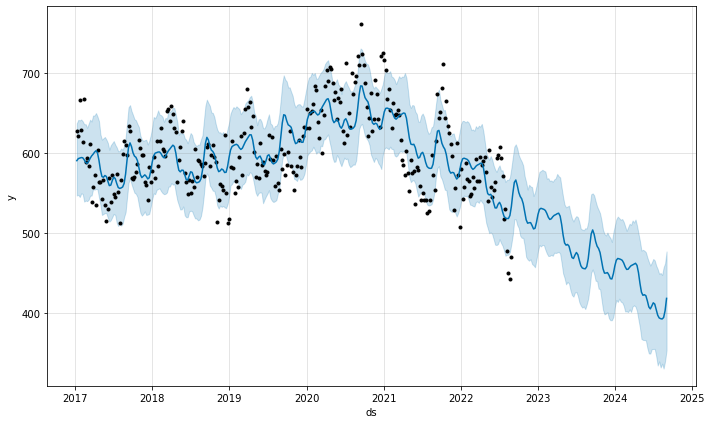

In [35]:
fig1 = m.plot(forecast)

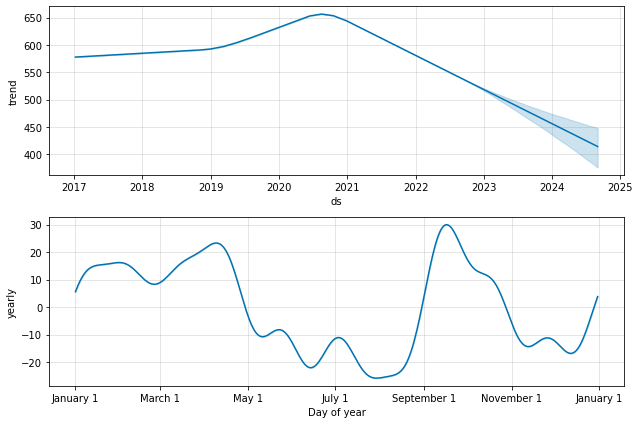

In [36]:
fig2 = m.plot_components(forecast)


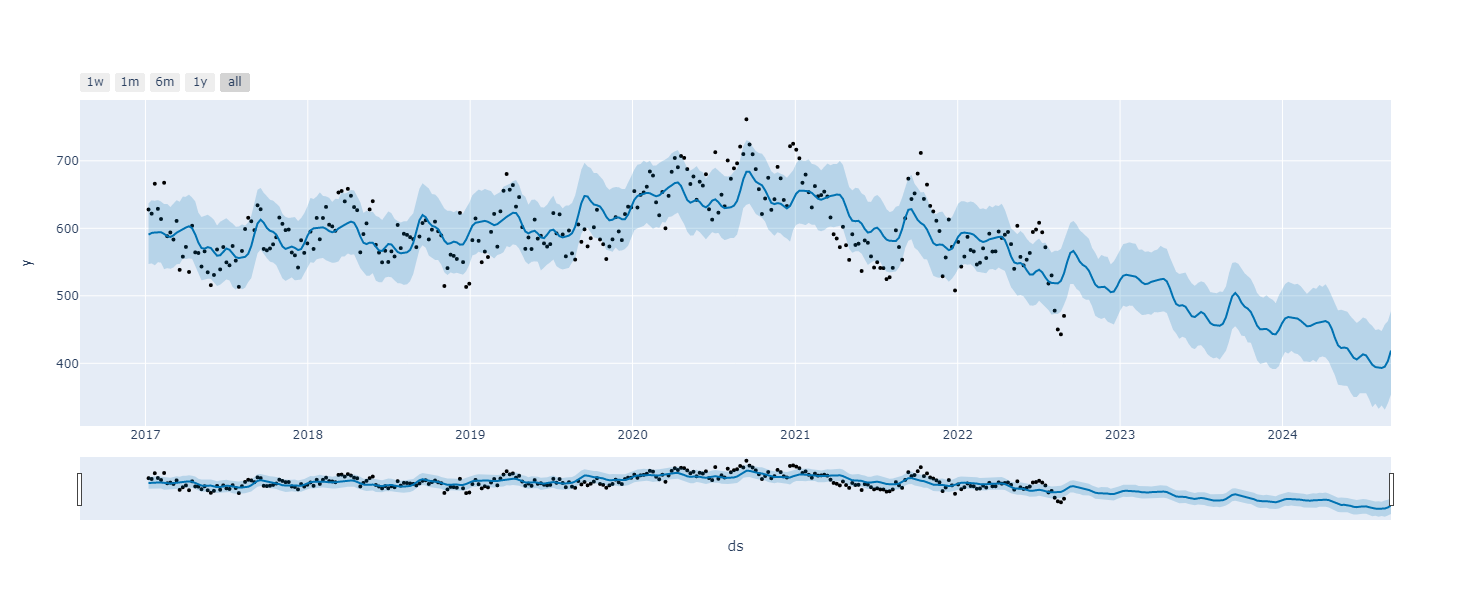

In [37]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

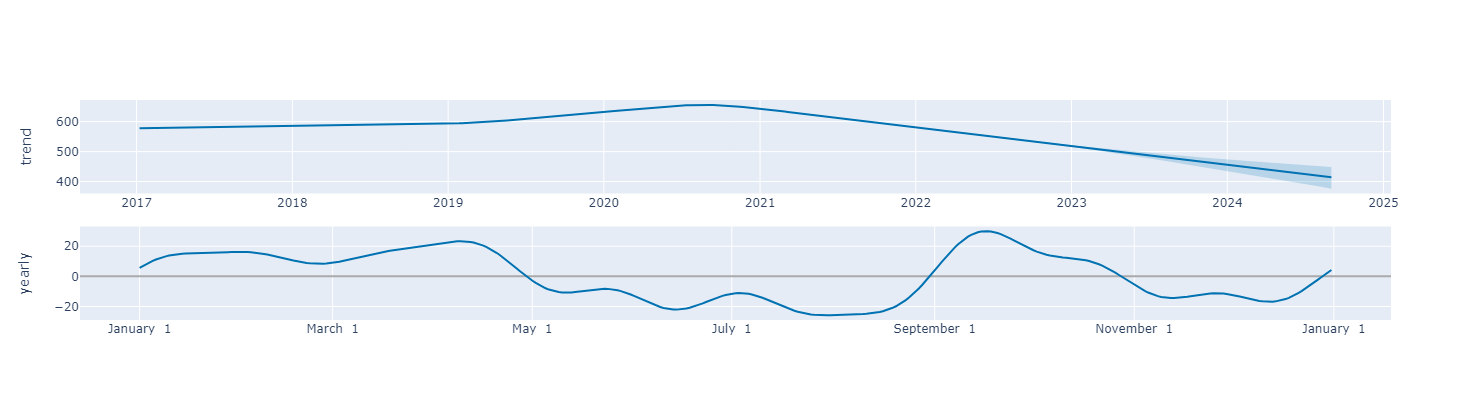

In [38]:
plot_components_plotly(m, forecast)


In [39]:
forecast.tail(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
397 2024-08-18  416.628719  331.257320  457.440401   379.337534   449.805044   
398 2024-08-25  415.429568  340.759017  462.543409   377.465403   449.053159   
399 2024-09-01  414.230417  353.974426  477.368797   375.783071   448.401649   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
397      -21.696037            -21.696037            -21.696037 -21.696037   
398      -12.065842            -12.065842            -12.065842 -12.065842   
399        4.570165              4.570165              4.570165   4.570165   

     yearly_lower  yearly_upper  multiplicative_terms  \
397    -21.696037    -21.696037                   0.0   
398    -12.065842    -12.065842                   0.0   
399      4.570165      4.570165                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
397                         0.0                         0.0  394.932682  
398                         0.0                         0.0  403.363725  
399                         0.0                         0.0  418.800581

#### Cross Validate

In [40]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 41 forecasts with cutoffs between 2021-01-15 00:00:00 and 2022-07-29 00:00:00


  0%|          | 0/41 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2021-01-17  724.173333  685.386950  762.722273  667.417673 2021-01-15
1 2021-01-24  727.457550  691.826703  764.641805  679.597139 2021-01-15
2 2021-01-31  734.075691  698.879340  772.003938  653.477419 2021-01-15

In [41]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon          mse       rmse        mae      mape     mdape     smape  \
0  2 days  3313.632888  57.564163  44.759333  0.073431  0.064038  0.072879   
1  9 days  4201.875537  64.821875  54.578896  0.092955  0.085645  0.090774   
2 16 days  4780.735073  69.142860  54.615780  0.091357  0.078152  0.089974   

   coverage  
0  0.560976  
1  0.365854  
2  0.487805

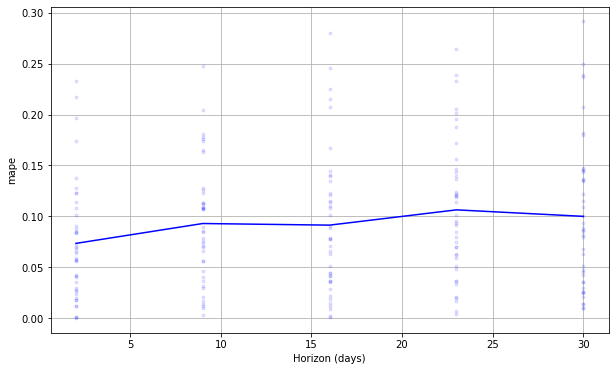

In [42]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [43]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for_aht, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly_AHT" "A1"
                WHERE
                    "A1"."Team" = '{team}'
                    
                    AND "A1"."DS" <= TO_DATE({end_date},'YYYY-MM-DD HH24:MI:SS')'''

with ods as conn:
    conn.execute(delete)

In [44]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly_AHT',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 400...Done. 0.1219327449798584 total seconds have elapsed.
